#0. Import library, define functons and constant

In [1]:
!pip install nltk
!pip install contractions
!pip install textsearch
!pip install flair
!pip install tensorflow-hub
!pip install fastai

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%%time

import contractions
import re
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from joblib import dump, load

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gensim
from gensim.models import Word2Vec, KeyedVectors

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential, model_from_json
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout, Activation
from tensorflow.python.keras import metrics
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub

from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

from pathlib import Path
from flair.data import Sentence

from fastai.text import *

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def report(y, predicted):
    target_names = ['Sincere', 'Insincere']
        
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    
    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
def plot_roc(y, predicted):
    #roc curve
    fpr, tpr, thresholds = roc_curve(y, predicted, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, 1- predicted, pos_label = 0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure()
    plt.plot(fpr, tpr, color ='blue', lw = 1, label = 'ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color ='red', lw = 1, label = 'ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color ='black', lw = 1, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")
    plt.show()
    
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        print("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, docs):
    return np.vstack([word_averaging(wv, doc) for doc in docs])
  
def  word_doc2vec_list(model, docs):
    return np.vstack([model.infer_vector(doc.split()) for doc in docs])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 2.57 s, sys: 306 ms, total: 2.87 s
Wall time: 3.07 s


In [0]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = path+"embeddings/glove.840B.300d/glove.840B.300d.txt"
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        #ALLmight
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 
    
            
def load_fasttext(word_index):    
    EMBEDDING_FILE = path+"embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = path+'embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]

    nb_words = min(num_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [0]:
num_words = 8000 
embedding_size = 300
max_tokens = 30
pad = 'post'
path = '/content/gdrive/My Drive/data/'

#1. simple clean up (keep the  numbers and no stemming)


In [6]:
train_data = pd.read_csv(path+'train.csv')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306122


In [7]:
%%time

train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(contractions.fix).apply(remove_white_space).str.lower().apply(remove_special_character)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))

train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
print(train_data.head())

dump(train_data, path+'train_data_project.sav')

Training data set: 1306116
   index                   qid  ... target  word_count
0      0  00002165364db923c7e6  ...      0          13
1      1  000032939017120e6e44  ...      0          16
2      2  0000412ca6e4628ce2cf  ...      0          10
3      3  000042bf85aa498cd78e  ...      0           9
4      4  0000455dfa3e01eae3af  ...      0          15

[5 rows x 5 columns]
CPU times: user 20.1 s, sys: 715 ms, total: 20.8 s
Wall time: 21.7 s


In [8]:
train_data_s = pd.concat([train_data.loc[(train_data['target'] == 0) & (train_data['question_text'].str.len() > 10)].sample(n=90000, random_state=42),\
                          train_data.loc[(train_data['target'] == 1) & (train_data['question_text'].str.len() > 10)].sample(n=80000, random_state=42)], ignore_index=True)
train_data_s = train_data_s.sample(frac=1).reset_index(drop=True)
print(len(train_data_s))
train_data_s.head()

170000


,index,qid,question_text,target,word_count
0,547219,6b33cc68f55a92c4e3fd,i am a boy why do girls tease me about my bare...,1,13
1,1037678,cb55798d61f833d3099b,is liberalism responsible for the destruction ...,1,17
2,90722,11c6586aa432d8ec7178,how many versions of airsoft gearboxes are the...,0,14
3,788433,9a78317ddaee91efe8b4,i have a gpa of 57 and a gamsat of 71 do i sta...,0,21
4,272982,356ec6ab950d75b38500,what would happen if spacecraft with american ...,0,20


In [9]:
train_text = train_data['question_text']
train_target = train_data['target']

dump(train_text, path+'train_text_project.sav')
dump(train_target, path+'target_project.sav')

['/content/gdrive/My Drive/data/target_project.sav']

In [10]:
train_text_s = train_data_s['question_text']
train_target_s = train_data_s['target']

dump(train_text_s, path+'train_text_s_project.sav')
dump(train_target_s, path+'target_s_project.sav')

['/content/gdrive/My Drive/data/target_s_project.sav']

#2. data split 80% (train) , 10% (dev) ,  10 %(test)

In [11]:
%%time

X_train, X_hold, y_train, y_hold  = train_test_split(train_text, train_target, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target)
X_dev, X_test, y_dev, y_test  = train_test_split(X_hold, y_hold, 
                                                     train_size = 0.5, test_size = 0.5,  
                                                     random_state = 42, stratify = y_hold)

print(len(X_train),len(X_dev), len(X_test))

1044892 130612 130612
CPU times: user 1.05 s, sys: 8.71 ms, total: 1.06 s
Wall time: 1.06 s


In [12]:
X_train_s, X_hold_s, y_train_s, y_hold_s  = train_test_split(train_text_s, train_target_s, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target_s)
X_dev_s, X_test_s, y_dev_s, y_test_s  = train_test_split(X_hold_s, y_hold_s, 
                                                     train_size = 0.5, test_size = 0.5,  
                                                     random_state = 42, stratify = y_hold_s)

print(len(X_train_s),len(X_dev_s), len(X_test_s))

136000 17000 17000


In [0]:
# print(X_train[0])
# tokenizer.texts_to_sequences(X_train[0]) 
# tokenizer.texts_to_sequences(X_train[0]) 

In [14]:
%%time

tokenizer = Tokenizer(num_words=num_words, lower=False, char_level=False)
tokenizer.fit_on_texts(train_data['question_text'])
dump(tokenizer, path+'tokenizer_project.sav')

CPU times: user 40 s, sys: 80.5 ms, total: 40.1 s
Wall time: 41 s


In [15]:
X_train_token  = tokenizer.texts_to_sequences(X_train)

dump(X_train, path+'X_train_project.sav')
dump(X_train_token, path+'X_train_token_project.sav')
dump(y_train, path+'y_train_project.sav')

['/content/gdrive/My Drive/data/y_train_project.sav']

In [16]:
X_dev_token  = tokenizer.texts_to_sequences(X_dev)

dump(X_dev, path+'X_dev_project.sav')
dump(X_dev_token, path+'X_dev_token_project.sav')
dump(y_dev, path+'y_dev_project.sav')

['/content/gdrive/My Drive/data/y_dev_project.sav']

In [17]:
X_test_token  = tokenizer.texts_to_sequences(X_test)

dump(X_test, path+'X_test_project.sav')
dump(X_test_token, path+'X_test_token_project.sav')
dump(y_test, path+'y_test_project.sav')

['/content/gdrive/My Drive/data/y_test_project.sav']

#3. BOW (TF-IDF)  logistic regression 

In [0]:
logreg = Pipeline([('vect', CountVectorizer(max_features=num_words, min_df=2, lowercase=False)),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

In [19]:
%%time

logreg.fit(X_train, y_train)

CPU times: user 40.4 s, sys: 1.6 s, total: 42 s
Wall time: 13min 2s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=1.0,
                                 max_features=8000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                  

              precision    recall  f1-score   support

     Sincere       0.99      0.89      0.94    122531
   Insincere       0.35      0.88      0.50      8081

    accuracy                           0.89    130612
   macro avg       0.67      0.88      0.72    130612
weighted avg       0.95      0.89      0.91    130612



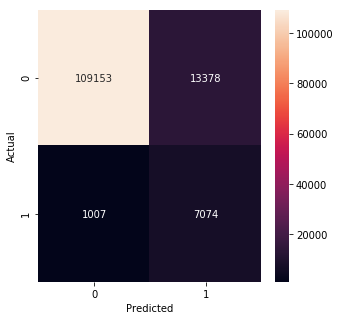

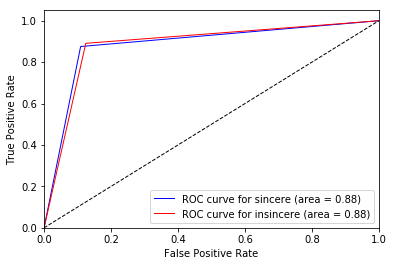

In [20]:
y_pred = logreg.predict(X_dev)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)

#4. word2Vec  logistic regression

In [0]:
%%time

word2Vec_model = Word2Vec(train_text.str.split(), size=embedding_size,min_count=2, workers=4)
word2Vec_model.save(path+"embeddings/word2vec.model")
#word2Vec_model = Word2Vec.load(path+"embeddings/word2vec.model")

CPU times: user 6min 3s, sys: 1.63 s, total: 6min 4s
Wall time: 3min 13s


In [0]:
word2Vec_model = Word2Vec.load(path+"embeddings/word2vec.model")
quorawv = word2Vec_model.wv
quorawv.init_sims(replace=True)
#del word2Vec_model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
X_train_word_average = word_averaging_list(quorawv,X_train.str.split())
X_dev_word_average = word_averaging_list(quorawv,X_dev.str.split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


cannot compute similarity with no input %s ['Dodnsskdkfockdndnsm', 'kddkdndkl', 'dkd', 'sksnwlfd', 'kss']
cannot compute similarity with no input %s ['Neigh', 'Whinny']
cannot compute similarity with no input %s ['OIL', 'Mgmjmj', 'Tgmgtj', 'mgmgjjjmgtjmjjjmgmj', 'amgjjjjj']
cannot compute similarity with no input %s ['ISRAEL', 'OHIM']
cannot compute similarity with no input %s ['Whoismost', 'powerfulman']
cannot compute similarity with no input %s ['math247math']


In [0]:
embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

In [0]:
%%time

embeddinglogreg.fit(X_train_word_average, y_train)

CPU times: user 1min, sys: 11.8 s, total: 1min 12s
Wall time: 1h 23min 6s


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.92    122531
   Insincere       0.30      0.88      0.45      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.88      0.69    130612
weighted avg       0.95      0.87      0.90    130612



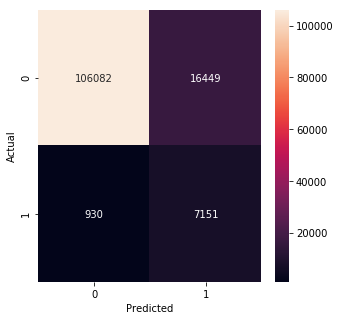

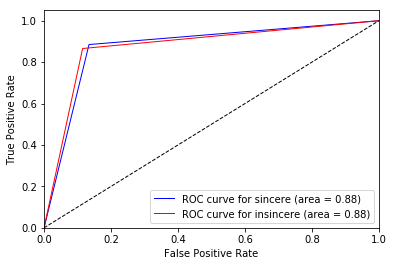

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)

#5. pre-trained word2Vec logistic regression

In [0]:
googlewv = KeyedVectors.load_word2vec_format(path+"embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)
googlewv.init_sims(replace=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
X_train_word_average = word_averaging_list(googlewv,X_train.str.split())
X_dev_word_average = word_averaging_list(googlewv,X_dev.str.split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


cannot compute similarity with no input %s ['Integeration', 'of', 'sinx']
cannot compute similarity with no input %s ['Whorote', 'gitanjali']


In [0]:
embeddinglogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

In [0]:
%%time

embeddinglogreg.fit(X_train_word_average, y_train)

CPU times: user 27.3 s, sys: 6.33 s, total: 33.6 s
Wall time: 8min 42s


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.99      0.87      0.93    122531
   Insincere       0.30      0.88      0.45      8081

    accuracy                           0.87    130612
   macro avg       0.65      0.87      0.69    130612
weighted avg       0.95      0.87      0.90    130612



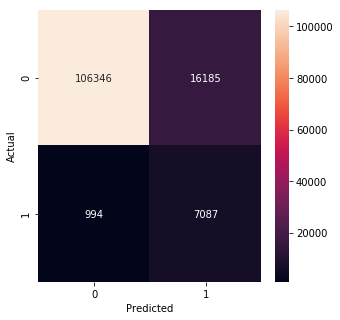

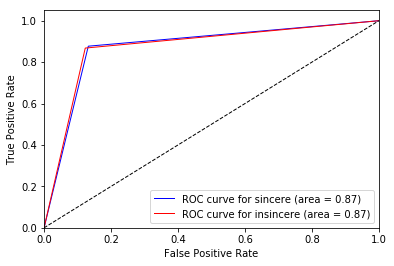

In [0]:
y_pred = embeddinglogreg.predict(X_dev_word_average)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)

In [0]:
#from gensim.models import KeyedVectors, Word2Vec
#from gensim.scripts.glove2word2vec import glove2word2vec

#glove2word2vec(path+"embeddings/glove.840B.300d/glove.840B.300d.txt", path+"embeddings/glove.840B.300d/temp.txt")
#glovewv = KeyedVectors.load_word2vec_format(path+"embeddings/glove.840B.300d/temp.txt", binary=False)

#word2Vec_model = Word2Vec.load(path+"embeddings/word2vec.model")
#quorawv = word2Vec_model.wv
#quorawv.init_sims(replace=True)
#del word2Vec_model

#wikiwv = KeyedVectors.load_word2vec_format(path+"embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec", binary=False)
#googlewv = KeyedVectors.load_word2vec_format(path+"embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin", binary=True)
#googlewv.init_sims(replace=True)


#6. doc2Vec logistic regression
https://radimrehurek.com/gensim/models/doc2vec.html

In [15]:
%%time

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc.split(), [i]) for i, doc in X_train.items()]


CPU times: user 6.12 s, sys: 704 ms, total: 6.82 s
Wall time: 6.82 s


In [0]:
%%time

doc2vec_model = Doc2Vec(documents, max_vocab_size=num_words, dm=1, alpha=0.065, min_alpha=0.00025, negative=5, min_count=2, vector_size=embedding_size, window=5, workers=4)

CPU times: user 6min 42s, sys: 3min 38s, total: 10min 21s
Wall time: 5min 35s


In [0]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile(path+"doc2vec_model")
doc2vec_model.save(fname)
doc2vec_model = Doc2Vec.load(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
doc2vec_model = Doc2Vec.load(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
%%time

X_train_doc2vec = word_doc2vec_list(doc2vec_model,X_train)
X_dev_doc2vec = word_doc2vec_list(doc2vec_model,X_dev)

In [0]:
doclogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

In [0]:
%%time

doclogreg.fit(X_train_doc2vec, y_train)

CPU times: user 38.2 s, sys: 3.66 s, total: 41.9 s
Wall time: 8min 35s


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.98      0.82      0.89    122531
   Insincere       0.21      0.74      0.32      8081

    accuracy                           0.81    130612
   macro avg       0.59      0.78      0.61    130612
weighted avg       0.93      0.81      0.85    130612



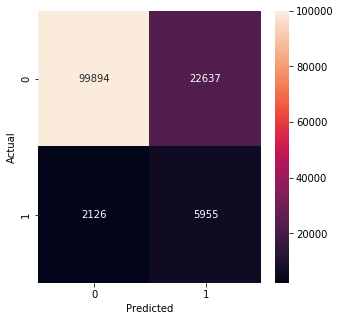

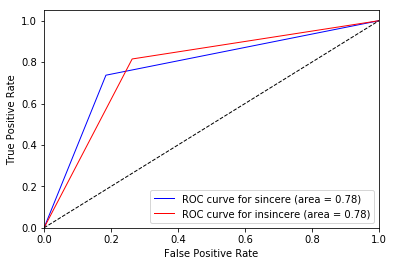

In [0]:
y_pred = doclogreg.predict(X_dev_doc2vec)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)

In [16]:
%%time

doc2vec_model = Doc2Vec(documents, max_vocab_size=num_words, dm=0, alpha=0.065, min_alpha=0.00025, negative=5, min_count=2, vector_size=embedding_size, window=5, workers=4)

CPU times: user 7min 46s, sys: 2min 47s, total: 10min 33s
Wall time: 6min 24s


In [17]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile(path+"doc2vec_model")
doc2vec_model.save(fname)
doc2vec_model = Doc2Vec.load(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [18]:
doc2vec_model = Doc2Vec.load(fname)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [21]:
%%time

X_train_doc2vec = word_doc2vec_list(doc2vec_model,X_train)
X_dev_doc2vec = word_doc2vec_list(doc2vec_model,X_dev)

CPU times: user 2min 51s, sys: 3.9 s, total: 2min 55s
Wall time: 2min 55s


In [0]:
doclogreg = Pipeline([('clf', LogisticRegressionCV(class_weight='balanced', cv=5, scoring='roc_auc', max_iter=1000,n_jobs=-1)),
                  ])

In [23]:
%%time

doclogreg.fit(X_train_doc2vec, y_train)

CPU times: user 1min 10s, sys: 14.8 s, total: 1min 24s
Wall time: 24min 28s


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='warn',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring='roc_auc', solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

              precision    recall  f1-score   support

     Sincere       0.98      0.81      0.89    122531
   Insincere       0.21      0.78      0.34      8081

    accuracy                           0.81    130612
   macro avg       0.60      0.80      0.61    130612
weighted avg       0.94      0.81      0.85    130612



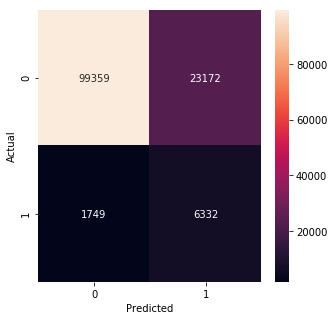

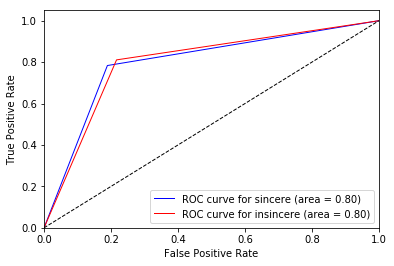

In [24]:
y_pred = doclogreg.predict(X_dev_doc2vec)
report(y_dev, y_pred)
plot_roc(y_dev, y_pred)

#7.  RNN with embedding layer 

In [0]:
%%time

X_train_token = load(path +'X_train_token_project.sav')
X_dev_token = load(path +'X_dev_token_project.sav')
X_train_pad = pad_sequences(X_train_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()
X_dev_pad = pad_sequences(X_dev_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()


CPU times: user 28.4 s, sys: 0 ns, total: 28.4 s
Wall time: 28.4 s


In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)

In [0]:
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens, name='layer_embedding'))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 30, 300)           2400000   
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 32)            31968     
_________________________________________________________________
gru_5 (GRU)                  (None, 30, 16)            2352      
_________________________________________________________________
gru_6 (GRU)                  (None, 30, 8)             600       
_________________________________________________________________
gru_7 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,435,081
Trainable params: 2,435,081
Non-trainable params: 0
____________________________________________

In [0]:
%%time

history = model.fit(np.array(X_train_pad), y_train, validation_data=(np.array(X_dev_pad),y_dev), epochs=5, batch_size=500)


Train on 1044892 samples, validate on 130612 samples
Epoch 1/5
1044892/1044892 [==============================] - 378s 362us/sample - loss: 0.1392 - auc_2: 0.9171 - acc: 0.9497 - val_loss: 0.1191 - val_auc_2: 0.9468 - val_acc: 0.9535
Epoch 2/5
1044892/1044892 [==============================] - 376s 360us/sample - loss: 0.1136 - auc_2: 0.9499 - acc: 0.9558 - val_loss: 0.1161 - val_auc_2: 0.9470 - val_acc: 0.9548
Epoch 3/5
1044892/1044892 [==============================] - 373s 357us/sample - loss: 0.1071 - auc_2: 0.9564 - acc: 0.9582 - val_loss: 0.1163 - val_auc_2: 0.9471 - val_acc: 0.9551
Epoch 4/5
1044892/1044892 [==============================] - 378s 361us/sample - loss: 0.1006 - auc_2: 0.9619 - acc: 0.9607 - val_loss: 0.1182 - val_auc_2: 0.9417 - val_acc: 0.9551
Epoch 5/5
1044892/1044892 [==============================] - 373s 357us/sample - loss: 0.0941 - auc_2: 0.9668 - acc: 0.9632 - val_loss: 0.1204 - val_auc_2: 0.9399 - val_acc: 0.9541
CPU times: user 52min 24s, sys: 6min 8s, t

In [0]:
%%time

predicted = model.predict(np.array(X_dev_pad))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])

CPU times: user 7min 50s, sys: 1min 3s, total: 8min 54s
Wall time: 4min 36s


              precision    recall  f1-score   support

     Sincere       0.97      0.98      0.98    122531
   Insincere       0.66      0.52      0.58      8081

    accuracy                           0.95    130612
   macro avg       0.82      0.75      0.78    130612
weighted avg       0.95      0.95      0.95    130612



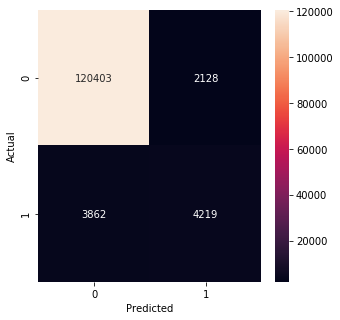

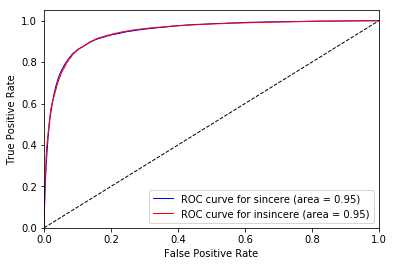

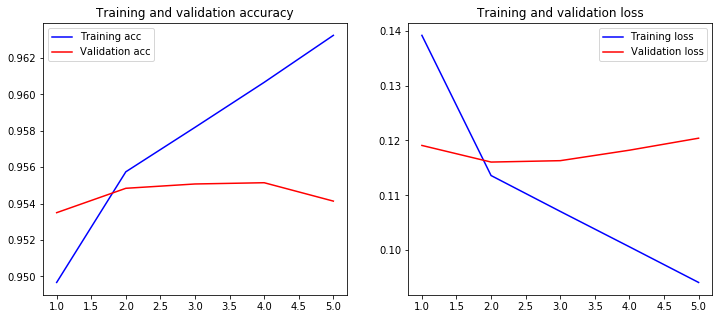

In [0]:
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)

#8. RNN with  pre-trained vector  

In [0]:
%%time

#paragram_embeddings = load_para(tokenizer.word_index) 
#fasttext_embeddings = load_fasttext(tokenizer.word_index) 
glove_embeddings = load_glove(tokenizer.word_index)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


CPU times: user 2min 21s, sys: 16.5 s, total: 2min 37s
Wall time: 2min 37s


In [0]:
%%time

X_train_token = load(path +'X_train_token_project.sav')
X_dev_token = load(path +'X_dev_token_project.sav')
X_train_pad = pad_sequences(X_train_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()
X_dev_pad = pad_sequences(X_dev_token, maxlen=max_tokens, padding=pad, truncating=pad).tolist()


CPU times: user 30.2 s, sys: 24.4 s, total: 54.7 s
Wall time: 54.9 s


In [0]:
del X_train_token, X_dev_token

In [0]:
model = Sequential()
optimizer = Adam(lr=1e-3)
model.add(Embedding(weights=[glove_embeddings], trainable=False, input_dim=num_words, output_dim=embedding_size, input_length=max_tokens))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, dropout=0.5, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 300)           2400000   
_________________________________________________________________
gru_21 (GRU)                 (None, 30, 32)            31968     
_________________________________________________________________
gru_22 (GRU)                 (None, 30, 16)            2352      
_________________________________________________________________
gru_23 (GRU)                 (None, 30, 8)             600       
_________________________________________________________________
gru_24 (GRU)                 (None, 4)                 156       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,435,081
Trainable params: 35,081
Non-trainable params: 2,400,000
_______________________________________

In [0]:
%%time

history = model.fit(np.array(X_train_pad), y_train, validation_data=(np.array(X_dev_pad),y_dev), epochs=4, batch_size=500)


Train on 1044892 samples, validate on 130612 samples
Epoch 1/4
1044892/1044892 [==============================] - 356s 341us/sample - loss: 0.1509 - auc_10: 0.9011 - acc: 0.9490 - val_loss: 0.1200 - val_auc_10: 0.9394 - val_acc: 0.9550
Epoch 2/4
1044892/1044892 [==============================] - 353s 337us/sample - loss: 0.1177 - auc_10: 0.9442 - acc: 0.9550 - val_loss: 0.1152 - val_auc_10: 0.9479 - val_acc: 0.9557
Epoch 3/4
1044892/1044892 [==============================] - 352s 337us/sample - loss: 0.1134 - auc_10: 0.9494 - acc: 0.9564 - val_loss: 0.1131 - val_auc_10: 0.9519 - val_acc: 0.9565
Epoch 4/4
1044892/1044892 [==============================] - 355s 340us/sample - loss: 0.1106 - auc_10: 0.9523 - acc: 0.9573 - val_loss: 0.1113 - val_auc_10: 0.9530 - val_acc: 0.9572
CPU times: user 40min 16s, sys: 4min 57s, total: 45min 13s
Wall time: 23min 44s


In [0]:
%%time

predicted = model.predict(np.array(X_dev_pad))
predicted = predicted.T[0]
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in predicted])

CPU times: user 7min 37s, sys: 1min 2s, total: 8min 39s
Wall time: 4min 29s


              precision    recall  f1-score   support

     Sincere       0.97      0.99      0.98    122531
   Insincere       0.71      0.53      0.60      8081

    accuracy                           0.96    130612
   macro avg       0.84      0.76      0.79    130612
weighted avg       0.95      0.96      0.95    130612



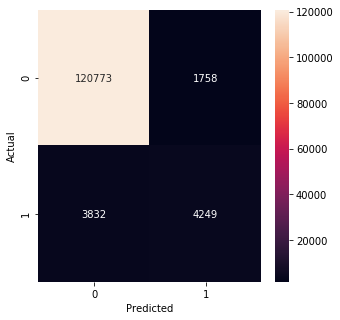

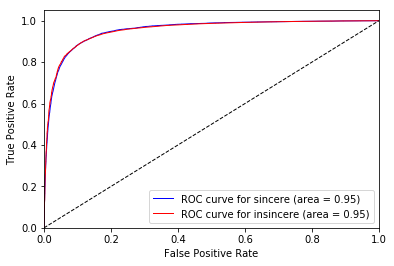

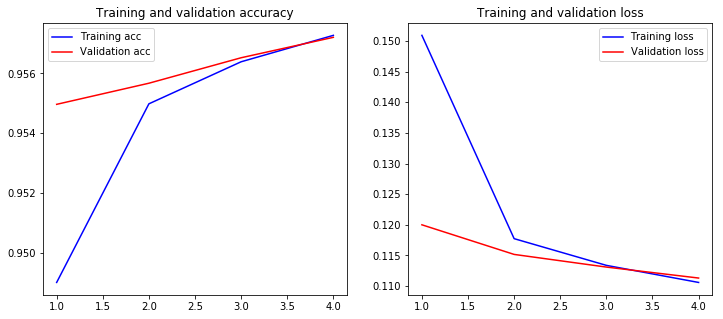

In [0]:
report(y_dev, cls_pred)
plot_roc(y_dev, predicted)
plot_history(history)

#9. pre-trained LM (Flair)

In [0]:
X = X_train_s.to_list() + X_test_s.to_list() + X_dev_s.to_list()
y = y_train_s.to_list() + y_test_s.to_list() + y_dev_s.to_list()


In [0]:
data = pd.DataFrame(list(zip(y, X)), columns =['label','text'])
data['label'] = '__label__' + data['label'].map({1: 'Insincere', 0: 'Sincere'})

data.iloc[0:int(len(data)*0.8)].to_csv(path+'flair/trainflair.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv(path+'flair/testflair.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv(path+'flair/devflair.csv', sep='\t', index = False, header = False);


In [0]:
data.head(3)

,label,text
0,__label__Insincere,Why are women in India overprivileged nowadays...
1,__label__Insincere,What is this Blue Whale suicide game that is t...
2,__label__Sincere,Which Mathematics book provides quality theory...


In [0]:
corpus = NLPTaskDataFetcher.load_classification_corpus(Path(path+'flair/'),\
                                                       test_file='testflair.csv',\
                                                       dev_file='devflair.csv',\
                                                       train_file='trainflair.csv')

word_embeddings = [WordEmbeddings('glove'),\
                   FlairEmbeddings('news-forward-fast'),\
                   FlairEmbeddings('news-backward-fast')]

document_embeddings = DocumentLSTMEmbeddings(word_embeddings,
                                             hidden_size=512,\
                                             reproject_words=True,\
                                             reproject_words_dimension=256)

classifier = TextClassifier(document_embeddings,\
                            label_dictionary=corpus.make_label_dictionary(),\
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

trainer.train(path+'flair/', max_epochs=20)

2019-08-12 22:41:10,822 Reading data from /content/gdrive/My Drive/data/flair
2019-08-12 22:41:10,824 Train: /content/gdrive/My Drive/data/flair/trainflair.csv
2019-08-12 22:41:10,826 Dev: /content/gdrive/My Drive/data/flair/devflair.csv
2019-08-12 22:41:10,827 Test: /content/gdrive/My Drive/data/flair/testflair.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:447: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:454: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  max_tokens_per_doc=max_tokens_per_doc,
/usr/local/lib/python3.6/dist-packages/flair/data_fetcher.py:463: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets

2019-08-12 22:42:00,196 {'Insincere', 'Sincere'}
2019-08-12 22:42:00,294 ----------------------------------------------------------------------------------------------------
2019-08-12 22:42:00,297 Evaluation method: MICRO_F1_SCORE
2019-08-12 22:42:00,751 ----------------------------------------------------------------------------------------------------
2019-08-12 22:42:01,558 epoch 1 - iter 0/4041 - loss 0.70203841
2019-08-12 22:42:59,033 epoch 1 - iter 404/4041 - loss 0.50237313
2019-08-12 22:43:50,773 epoch 1 - iter 808/4041 - loss 0.46344586
2019-08-12 22:44:47,785 epoch 1 - iter 1212/4041 - loss 0.43926166
2019-08-12 22:45:44,691 epoch 1 - iter 1616/4041 - loss 0.42628143
2019-08-12 22:46:36,232 epoch 1 - iter 2020/4041 - loss 0.41650157
2019-08-12 22:47:33,220 epoch 1 - iter 2424/4041 - loss 0.40808239
2019-08-12 22:48:29,575 epoch 1 - iter 2828/4041 - loss 0.39953352
2019-08-12 22:49:20,662 epoch 1 - iter 3232/4041 - loss 0.39447210
2019-08-12 22:50:18,748 epoch 1 - iter 3636/4

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


2019-08-13 02:42:55,379 0.898	0.898	0.898
2019-08-13 02:42:55,385 
MICRO_AVG: acc 0.8148 - f1-score 0.898
MACRO_AVG: acc 0.8148 - f1-score 0.89795
Insincere  tp: 7385 - fp: 954 - fn: 695 - tn: 7127 - precision: 0.8856 - recall: 0.9140 - accuracy: 0.8175 - f1-score: 0.8996
Sincere    tp: 7127 - fp: 695 - fn: 954 - tn: 7385 - precision: 0.9111 - recall: 0.8819 - accuracy: 0.8121 - f1-score: 0.8963
2019-08-13 02:42:55,386 ----------------------------------------------------------------------------------------------------


{'dev_loss_history': [tensor(0.3253, device='cuda:0'),
  tensor(0.3074, device='cuda:0'),
  tensor(0.3032, device='cuda:0'),
  tensor(0.3096, device='cuda:0'),
  tensor(0.2876, device='cuda:0'),
  tensor(0.2898, device='cuda:0'),
  tensor(0.3067, device='cuda:0'),
  tensor(0.2957, device='cuda:0'),
  tensor(0.2886, device='cuda:0'),
  tensor(0.2924, device='cuda:0'),
  tensor(0.3148, device='cuda:0'),
  tensor(0.2760, device='cuda:0'),
  tensor(0.2935, device='cuda:0'),
  tensor(0.2885, device='cuda:0'),
  tensor(0.2868, device='cuda:0'),
  tensor(0.3006, device='cuda:0'),
  tensor(0.2759, device='cuda:0'),
  tensor(0.2719, device='cuda:0'),
  tensor(0.2701, device='cuda:0'),
  tensor(0.2701, device='cuda:0')],
 'dev_score_history': [0.8679,
  0.8779,
  0.8802,
  0.8764,
  0.8879,
  0.8876,
  0.8752,
  0.8798,
  0.8901,
  0.8828,
  0.8728,
  0.8923,
  0.887,
  0.8847,
  0.885,
  0.8806,
  0.8922,
  0.8943,
  0.8939,
  0.8949],
 'test_score': 0.898,
 'train_loss_history': [0.38516628782

In [0]:
classifier = TextClassifier.load(path+'flair/best-model.pt')

2019-08-13 02:42:55,477 loading file /content/gdrive/My Drive/data/flair/best-model.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


In [0]:
%%time

sentences =[]

for s in X_dev.to_list():
  sentences.append(Sentence(s))

classifier.predict(sentences)

CPU times: user 6min 7s, sys: 1min 22s, total: 7min 30s
Wall time: 7min 30s


              precision    recall  f1-score   support

     Sincere       0.99      0.88      0.93    122531
   Insincere       0.34      0.92      0.50      8081

    accuracy                           0.88    130612
   macro avg       0.67      0.90      0.72    130612
weighted avg       0.95      0.88      0.91    130612



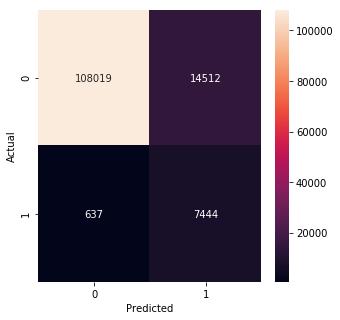

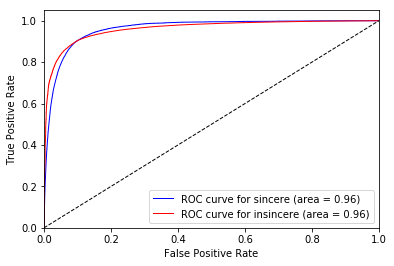

In [0]:
cls_pred, prob, prob_adj = [], [], []

for s in sentences:
  if s.labels[0].value == 'Sincere':
    cls_pred.append(0)
  else:
    cls_pred.append(1)
  prob.append(s.labels[0].score)

for i in range(0, len(prob)):
  if cls_pred[i] == 0:
    prob_adj.append(1-prob[i])
  else:
    prob_adj.append(prob[i])

report(y_dev, cls_pred)
plot_roc(y_dev.values, np.asarray(prob_adj))

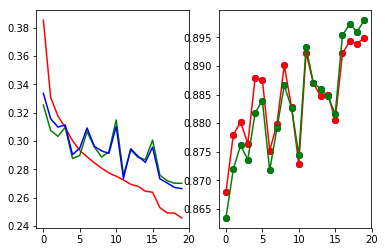

In [0]:
log = pd.read_csv(path+'flair/loss.tsv', sep='\t')
plt.figure(1)
plt.subplot(121)
plt.plot(log['EPOCH'], log['TRAIN_LOSS'], 'r', log['EPOCH'], log['DEV_LOSS'], 'g', log['EPOCH'], log['TEST_LOSS'], 'b')

plt.subplot(122)
plt.plot(log['EPOCH'], log['DEV_PRECISION'] ,'r')
plt.plot(log['EPOCH'], log['DEV_RECALL'] ,'bo')
plt.plot(log['EPOCH'], log['DEV_F1'], 'ro')
plt.plot(log['EPOCH'], log['TEST_PRECISION'], 'g')
plt.plot(log['EPOCH'], log['TEST_RECALL'], 'bo')
plt.plot(log['EPOCH'], log['TEST_F1'], 'go')
plt.show()

In [0]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
EPOCH             20 non-null int64
TIMESTAMP         20 non-null object
BAD_EPOCHS        20 non-null int64
LEARNING_RATE     20 non-null float64
TRAIN_LOSS        20 non-null float64
DEV_LOSS          20 non-null float64
DEV_PRECISION     20 non-null float64
DEV_RECALL        20 non-null float64
DEV_F1            20 non-null float64
TEST_LOSS         20 non-null float64
TEST_PRECISION    20 non-null float64
TEST_RECALL       20 non-null float64
TEST_F1           20 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 2.1+ KB


#10. pre-trained LM

In [13]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


In [16]:
dataset = pd.read_csv(path+'movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [17]:
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:30000]
train_sentiments = sentiments[:30000]

val_reviews = reviews[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]
train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000,), (5000,), (15000,))

In [0]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)



def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def pre_process_document(document):
    
    # strip HTML
    document = strip_html_tags(document)
    
    # lower case
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)
               
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
        
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [0]:

train_reviews = pre_process_corpus(train_reviews)
val_reviews = pre_process_corpus(val_reviews)
test_reviews = pre_process_corpus(test_reviews)


numpy.ndarray

In [0]:
train_reviews = X_train_s.values
train_sentiments = y_train_s.values

val_reviews = X_dev_s.values
val_sentiments = y_dev_s.values

test_reviews = X_test_s.values
test_sentiments = y_test_s.values

# reviews = dataset['review'].values
# sentiments = dataset['sentiment'].values

# train_reviews = reviews[:30000]
# train_sentiments = sentiments[:30000]

# val_reviews = reviews[30000:35000]
# val_sentiments = sentiments[30000:35000]

# test_reviews = reviews[35000:]
# test_sentiments = sentiments[35000:]
# train_reviews.shape, val_reviews.shape, test_reviews.shape

In [27]:
print(train_reviews[1])
print(train_sentiments[1])

are there any job openings for mechanical engineers m tech at carl zeiss are  d bengaluru
0


In [28]:
length_checker = np.vectorize(len) 
min(length_checker(train_reviews))

11

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, 
    batch_size=256, num_epochs=None, shuffle=True)

In [0]:
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)


In [0]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

In [0]:
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)

In [0]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [34]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))


2019-08-15 21:13:07,232 Using temporary folder as model directory: /tmp/tmpync_0vl8


In [64]:
256*1500 / 30000


12.8

In [65]:
256*3000/129291

5.940088637260134

In [35]:
tf.logging.set_verbosity(tf.logging.ERROR)
import time

TOTAL_STEPS = 500 #1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 45.87247276306152
Eval Metrics (Train): {'accuracy': 0.89007354, 'accuracy_baseline': 0.5294118, 'auc': 0.95145154, 'auc_precision_recall': 0.9391008, 'average_loss': 0.2788824, 'label/mean': 0.47058824, 'loss': 35.680157, 'precision': 0.8673717, 'prediction/mean': 0.48435017, 'recall': 0.90475, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 0.8959412, 'accuracy_baseline': 0.5294118, 'auc': 0.95299196, 'auc_precision_recall': 0.9380065, 'average_loss': 0.2732777, 'label/mean': 0.47058824, 'loss': 34.93023, 'precision': 0.8713792, 'prediction/mean': 0.4850019, 'recall': 0.91375, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 42.181029319763184
Eval Metrics (Train): {'accuracy': 0.8927721, 'accuracy_baseline': 0.5294118, 'au

In [36]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.8998015,
 'accuracy_baseline': 0.5294118,
 'auc': 0.9588581,
 'auc_precision_recall': 0.9484142,
 'average_loss': 0.25527248,
 'global_step': 600,
 'label/mean': 0.47058824,
 'loss': 32.659508,
 'precision': 0.88060445,
 'prediction/mean': 0.4778349,
 'recall': 0.9105312}

In [37]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.905,
 'accuracy_baseline': 0.5294118,
 'auc': 0.9600134,
 'auc_precision_recall': 0.9499414,
 'average_loss': 0.25042436,
 'global_step': 600,
 'label/mean': 0.47058824,
 'loss': 32.00913,
 'precision': 0.89023346,
 'prediction/mean': 0.47398505,
 'recall': 0.910375}

In [0]:
import time

TOTAL_STEPS = 1500
STEP_SIZE = 500

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)
  
    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('-'*100)
        print('Training for step =', step)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

In [39]:
tf.logging.set_verbosity(tf.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='/storage/models/nnlm-en-dim128_f/')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='/storage/models/nnlm-en-dim128_t/')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='/storage/models/use-512_f/')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='/storage/models/use-512_t/')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 9.772325992584229
Eval Metrics (Train): {'accuracy': 0.8642132, 'accuracy_baseline': 0.5294118, 'auc': 0.9345158, 'auc_precision_recall': 0.92074466, 'average_loss': 0.32573068, 'label/mean': 0.47058824, 'loss': 41.673916, 'precision': 0.8445137, 'prediction/mean': 0.47690755, 'recall': 0.872, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.86917645, 'accuracy_baseline': 0.5294118, 'auc': 0.93726027, 'auc_precision_recall': 0.9233717, 'average_loss': 0.31850848, 'label/mean': 0.47058824, 'loss': 40.71161, 'precision': 0.84870803, 'prediction/mean': 0.47637212, 'recall': 0.878625, 'global_step': 500}
----------------------------------------------------------------------------------------------------
Training for step = 500
Train Time (s): 8.434961557388306
Eval

In [40]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,Model Dir,Training Accuracy,Test Accuracy,Training AUC,Test AUC,Training Precision,Test Precision,Training Recall,Test Recall
nnlm-en-dim128,/storage/models/nnlm-en-dim128_f/,0.875757,0.873588,0.943423,0.941957,0.868032,0.866466,0.867938,0.864625
nnlm-en-dim128-with-training,/storage/models/nnlm-en-dim128_t/,0.935551,0.896176,0.977399,0.956527,0.923341,0.887123,0.941188,0.893000
use-512,/storage/models/use-512_f/,0.908816,0.909588,0.964557,0.963730,0.888377,0.892697,0.922094,0.918250
use-512-with-training,/storage/models/use-512_t/,0.998478,0.903059,0.999811,0.946871,0.997396,0.894338,0.999375,0.900375


In [41]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

'/storage/models/use-512_f/'

In [58]:
!ls /

bin	 datalab  home	 lib64	opt   run   storage  tensorflow-2.0.0b1  usr
boot	 dev	  lib	 media	proc  sbin  swift    tmp		 var
content  etc	  lib32  mnt	root  srv   sys      tools


In [42]:
embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [0]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [44]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0]

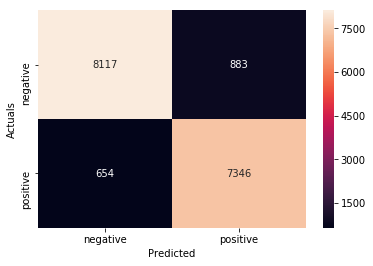

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.93      0.90      0.91      9000
    positive       0.89      0.92      0.91      8000

    accuracy                           0.91     17000
   macro avg       0.91      0.91      0.91     17000
weighted avg       0.91      0.91      0.91     17000



#11. pre-trained LM  (FastAI/ULMFiT)

In [0]:
## use raw data ?
# fast ai need minimum text preprocessing  should we used raw data ? 

trn_texts = X_train_s.values
trn_labels = y_train_s.values
val_texts = X_test_s.values
val_labels = y_test_s.values


np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]
trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val)

In [0]:
#data_lm.show_batch()

In [0]:
#data_lm.vocab.itos[:20]

In [0]:
# save and load
data_lm.save('tmp_lm') # so we can load back forward and backward


In [50]:
#data_lm = TextClasDataBunch.load(path+'fastai', 'tmp_lm')
data_lm_test = load_data(path+'fastai', 'tmp_lm') #forward
data_lm_test.show_batch()
data_bwd_test = load_data(path+'fastai', 'tmp_lm',backwards=True) #backward
data_bwd_test.show_batch()



idx,text
0,clinton from draft dodging xxbos how can i be less introvert xxbos how much time does it take to burn alive when a litre of gasoline is used xxbos do people who hate donald trump think hillary clinton would have been a good president or simply the lesser of two evils xxbos are small nuclear missiles good for counter battery fire xxbos is it easier to loose weight at sea
1,related to ipl matches xxbos if your child was sick and no treatments helped would you let them decide their fate xxbos do you have to stay in the usa for the entire duration of a j1 visa or can you leave early and not return xxbos what are some of the things that we should never tell anybody in our lives xxbos why do idiots believe that xxunk exists
2,of the sudden what should i do xxbos which is the best american football league in europe xxbos what are some literary devices found in xxunk wally xxunk poems xxbos why does not looks matter any more in bollywood as proved by xxunk xxunk or zakir khan xxbos why does mouth of muslims shuts up when hindus are killed in west bengal i am searching for secularism xxbos does not
3,what is your plan for the overwhelming burden of hydro costs in ontario xxbos why do i never want to hear you say i want it that way xxbos if more and more people move to new zealand because they believe it is an apocalyptic xxunk do you think this could make it an undesirable place to live in the future xxbos how are indian writers generally perceived by clients
4,people die out and are replaced by other people xxbos what would happen to a colony on the moon if earth was destroyed xxbos what is the best to purchase a handgun in california xxbos is not it gay for a woman to watch porn with a guy and a girl xxbos what is the fastest way my tunisian boyfriend can get a green card xxbos how can evangelicals vote


idx,text
0,fuck to chance a get you if xxbos women like act will men when end feminism will xxbos languages learning and traveling to related profession the is what xxbos made spacex was how xxbos world the in evil the all blame to atheists for scapegoat a god is xxbos understood become i that so xxunk better a become i do how me to obvious seem which people other to things
1,for worthwhile something do blm not does why xxbos emergency other or fire a is there if incarcerated those to happens what xxbos germany frankfurt in live to need you do much how xxbos male a was xxunk sarah and female a was reese kyle if better been have it would terminator the in xxbos bill electric the reduce that condition xxunk work inverter the how xxbos readers lifelong nurture
2,for cancer a islam is xxbos people many kill to shown been has it if used still vaccine tetanus xxunk xxunk xxunk the is why xxbos corporates for websites legal of use the is what xxbos person inteligent an of characteristics the are what xxbos india in purchase for available not disks hard ssd internal are why xxbos bible or catholicism their using argues filipino do why xxbos york new
3,weaponizing feminazis are why xxbos effect franklin benjamin the behind truth any there is xxbos india of image projected governments indian the in reflected highly is jingoism indian north statement the in is believe you do truth much how xxbos drinking been has texting am i person the if know i do how xxbos president he is why stupid is trump and liberals smart many so are there if xxbos
4,start i can how xxbos included meat no eggs is protein of source primary my and diet keto a on am i if day a in consume i should whole eggs many how xxbos not are they if them about say it does what own their than other country a in xxunk and come immigrants legal towards accepting or open be to xxunk an for beneficial it is xxbos xxunk


![alt text](https://miro.medium.com/max/1400/1*9J_7_aT_D7b-AcKtv5NPOQ.png)

In [0]:
# Language model
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
#learner = learner.to_fp16(clip=0.1)

In [52]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


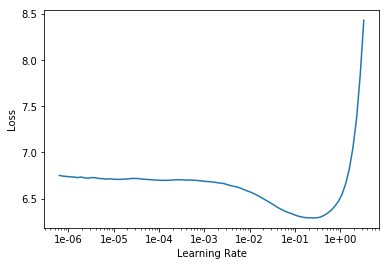

In [179]:
learner.recorder.plot()

In [53]:
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.842989,4.582369,0.243549,04:31


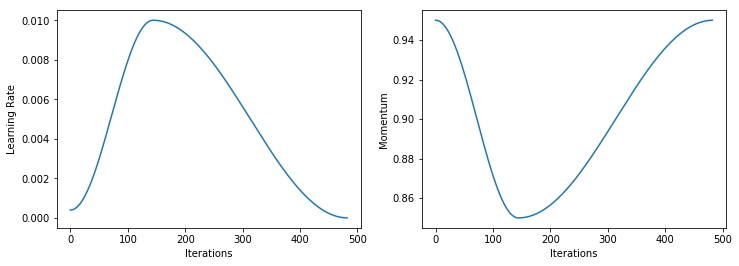

In [181]:
learner.recorder.plot_lr(show_moms=True)

In [54]:
learner.unfreeze()
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.367025,4.327241,0.267213,05:21


In [0]:
learner.save_encoder('ft_enc')

In [56]:
learner = language_model_learner(data_bwd_test, AWD_LSTM)
#learner = learner.to_fp16(clip=0.1)
#learner.fit_one_cycle(1, 2e-2, moms=(0.8,0.7), wd=0.1)
learner.fit_one_cycle(1, 1e-2)
learner.unfreeze()
#learner.fit_one_cycle(10, 2e-3, moms=(0.8,0.7), wd=0.1)
learner.fit_one_cycle(10, 1e-3)
learner.save_encoder('bwd_enc')

epoch,train_loss,valid_loss,accuracy,time
0,5.061719,4.644216,0.276288,04:31


epoch,train_loss,valid_loss,accuracy,time
0,4.654532,4.470479,0.294734,05:21
1,4.518621,4.361724,0.307725,05:21
2,4.412414,4.292455,0.315394,05:21
3,4.298453,4.247098,0.319950,05:21
4,4.196565,4.217056,0.323116,05:21
5,4.098351,4.200716,0.325011,05:22
6,4.010314,4.195939,0.326350,05:22
7,3.939846,4.191340,0.327126,05:22
8,3.903193,4.192837,0.327283,05:22
9,3.870728,4.194100,0.327357,05:22


In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [58]:

data_clas_bwd = TextClasDataBunch.from_df(path+'fastai', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32, backwards=True)
data_clas_bwd.show_batch()

text,target
jesus not you as life your live and spirit and will own your improve and experience to want you not do be may it perfect however spirit elses someone of zombie a as living like you do that all and mine not will thy spirit own our suppressing and you into jesus of spirit the in inviting mean christian a being does you to xxbos,1
either right seem not does it hiding week a only for a job the in been have i them tell i do how but interview to want i offer this accepted i before applied i job nice a for interview an for asked got i and job new a started just have i xxbos,0
myself changing not am i no and fire on myself light could i angry so am i shit break to want and compassion no have bitch stupid every and myself shoot to want life and everyone hate up fed miserable bitter a am i angry being from die i can xxbos,1
he has do to going was he thought actually you what to curious am i it to pollution more adding is he basis daily a on tell can i best and swamp the drain to in trump voted you because is really swamp the think you do what supporters trump xxbos,1
media mainstream their from story the of third a getting only ever are they realize not they do search google a of page first the at digging stop just they do news the of truth simple the out find not can they that obtuse this really liberals are xxbos,1


In [59]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (136000 items)
x: TextList
xxbos what could i call a robot for xxunk or first aid,xxbos do sp jains profile based interviews take place only in mumbai,xxbos are young white americans culture vultures,xxbos are jews bitter toward germany as a result of the xxunk,xxbos who was the to hit six in one over in ipl
y: CategoryList
0,0,1,1,0
Path: /content/gdrive/My Drive/data/fastai;

Valid: LabelList (17000 items)
x: TextList
xxbos should america take a decisive step against white nationalists and get tough by xxunk the death penalty against them when they eventually commit an act of violence,xxbos why did the russians murder litvinenko with xxunk instead of anonymously,xxbos can i publish a vietnamese language book on amazon,xxbos how can ethics be built into a business model,xxbos how can we download jio join app through app store it is not in apple store
y: CategoryList
1,1,0,0,0
Path: /content/gdrive/My Drive/data/fastai;

Test: None, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


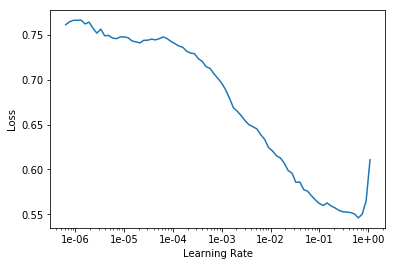

In [188]:
classifier.lr_find()
classifier.recorder.plot()

In [60]:
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.384930,0.306619,0.878882,02:41


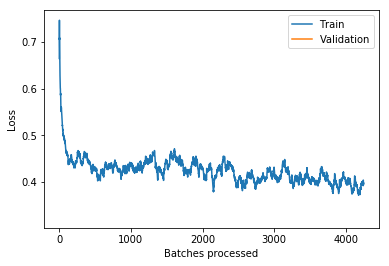

In [191]:
classifier.recorder.plot_losses()

In [61]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.350680,0.272787,0.897765,03:08


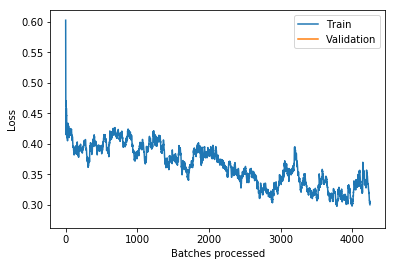

In [194]:
classifier.recorder.plot_losses()

In [62]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.293536,0.255543,0.904765,07:09


In [0]:
classifier.save('fwd_clas')

In [64]:
learn_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_bwd.load_encoder('bwd_enc')

learn_bwd.fit_one_cycle(1, 1e-2) # .fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)
learn_bwd.freeze_to(-2)
# lr /= 2
learn_bwd.fit_one_cycle(1, slice(5e-3/2., 5e-3)) #.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
#learn_bwd.freeze_to(-3)
#lr /= 2
#learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
learn_bwd.unfreeze()
#lr /= 5
learn_bwd.fit_one_cycle(1, slice(2e-3/100, 2e-3)) #.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
learn_bwd.save('bwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.416039,0.340573,0.864471,02:40


epoch,train_loss,valid_loss,accuracy,time
0,0.347580,0.266977,0.897765,03:09


epoch,train_loss,valid_loss,accuracy,time
0,0.277892,0.249157,0.904529,07:10


In [0]:
pred_fwd,lbl_fwd = classifier.get_preds()
pred_bwd,lbl_bwd = learn_bwd.get_preds()
final_pred = (pred_fwd+pred_bwd)/2


In [75]:
accuracy(final_pred, lbl_fwd)


tensor(0.9105)

In [86]:
predictions_2 = np.argmax(final_pred, axis = 1)
pd.crosstab(predictions_2, targets)

col_0,0,1
row_0,,
0,8114,636
1,886,7364


In [79]:
final_pred

tensor([[0.0747, 0.9253],
        [0.1028, 0.8972],
        [0.4737, 0.5263],
        ...,
        [0.2177, 0.7823],
        [0.8875, 0.1125],
        [0.4797, 0.5203]])

In [81]:
pred_fwd

tensor([[0.1208, 0.8792],
        [0.1068, 0.8932],
        [0.4773, 0.5227],
        ...,
        [0.0863, 0.9137],
        [0.9443, 0.0557],
        [0.5273, 0.4727]])

In [78]:
lbl_fwd

tensor([0, 1, 0,  ..., 1, 0, 1])

In [69]:
accuracy(final_pred, lbl_fwd)

tensor(0.9105)

In [70]:
preds, targets = classifier.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,8105,724
1,895,7276


In [0]:
pre = classifier.predict('why I cannot get the decent calssification')

In [72]:
print(pre)
print(pre[2].tolist())

(Category 0, tensor(0), tensor([0.6191, 0.3809]))
[0.6191100478172302, 0.3808899521827698]


In [0]:
from fastai.vision import *
preds, y, losses = classifier.get_preds(with_loss=True)

In [0]:
#report(y_dev_s, y)

In [0]:
#interp = ClassificationInterpretation(data_clas, preds, y, losses)

In [0]:
#interp.plot_confusion_matrix()

#Reference
[Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)